# Momentum Switch Cash

**Instrument:** Cash and Nifty 200 Momentum 30 Index, available on NSE and as Mutual Funds

**Action:** If the momentum slows down, switch to cash. If the momentum picks up, switch to Nifty 200 Momentum 30 Index.

**Why?** Momentum is a factor that has been shown to outperform the market over long periods of time. However, momentum is also known to have large negative deviation. This strategy aims to reduce the downside of the momentum factor by switching to cash when the momentum slows down.

**How to select when to exit?** The strategy uses a 3-month momentum window. We calculate the MOMENTUM_PERCENT_CHANGE as the percentage change in the momentum index over the last 3 months. If MOMENTUM_PERCENT_CHANGE is less than a threshold value called "to_cash", the strategy exits to cash. If the MOMENTUM_PERCENT_CHANGE is higher than "to_momentum" threshold, the strategy enters the momentum index. If the momentum is between "to_cash" and "to_momentum", the strategy stays in whatever is the most recent state i.e. CASH or MOMENTUM.

How to select the thresholds? The thresholds are selected by plotting the MOMENTUM_PERCENT_CHANGE and selecting the values that are most appropriate. The thresholds are selected such that the strategy:

1. Does NOT switch too often.
2. Does NOT stay in cash for too long
3. Does leave Momentum when the momentum is slowing down, even if it is still positive

The thresholds are selected such that the strategy switches to cash when the momentum is slowing down and switches to momentum when the momentum is picking up.

In [15]:
import pandas as pd
import numpy as np
from typing import Optional

# Correcting the DataPrep class again, this time accounting for the trailing spaces in column names
class DataPrep:
    def __init__(self, daily_file: str, monthly_file: str):
        self.daily_df = pd.read_csv(daily_file)
        self.monthly_df = pd.read_csv(monthly_file)
        self.month_col = "MONTH"
        self.prep_monthly_data()
        self.latest_df = None

    def prep_monthly_data(self) -> Optional[pd.DataFrame]:
        # Remove trailing spaces from column names
        self.monthly_df.columns = self.monthly_df.columns.str.strip()
        self.monthly_df[self.month_col] = pd.to_datetime(
            self.monthly_df["MONTH"], format="%b-%y"
        )

    def prepare_data(self) -> Optional[pd.DataFrame]:
        month_col = self.month_col
        # Remove trailing spaces from column names
        self.daily_df.columns = self.daily_df.columns.str.strip()
        self.daily_df["Date"] = pd.to_datetime(self.daily_df["Date"], format="%d-%b-%Y")

        # Create 'MONTH (Closing Values)' in a copy of daily_df
        daily_monthly_df = self.daily_df.copy()[["Date", "Close"]]
        daily_monthly_df[month_col] = (
            daily_monthly_df["Date"].dt.to_period("M").dt.strftime("%b-%y")
        )
        daily_monthly_df[month_col] = pd.to_datetime(
            daily_monthly_df[month_col], format="%b-%y"
        )
        daily_monthly_df = daily_monthly_df.drop("Date", axis=1)  # Drop 'Date' column
        # Group by 'MONTH (Closing Values)' and take the last record
        daily_monthly_df = daily_monthly_df.groupby(month_col).last().reset_index()

        # Sort by 'MONTH (Closing Values)', oldest to newest
        daily_monthly_df = daily_monthly_df.sort_values(month_col, ascending=True)

        # print(daily_monthly_df[month_col].value_counts())
        # for MONTH which are present in both daily_monthly_df and monthly_df, drop the values in monthly_df
        self.monthly_df = self.monthly_df[
            ~self.monthly_df[month_col].isin(daily_monthly_df[month_col])
        ]
        self.latest_df = pd.concat([daily_monthly_df, self.monthly_df])
        # Sort by 'Date', oldest to newest
        self.latest_df = self.latest_df.sort_values(month_col, ascending=True)
        print(self.latest_df.head())
        print(self.latest_df.tail())
        print(self.latest_df[month_col].nunique())

        # Convert Close to float, strip commas and round to 2 decimal places
        self.latest_df["Close"] = (
            self.latest_df["Close"]
            .astype(str)
            .str.replace(",", "")
            .astype(float)
            .round(2)
        )
        return self.latest_df


# Prepare the data
data_prep = DataPrep(
    daily_file="../data/NIFTY200 MOMENTUM 30-9-09-2022-to-9-09-2023.csv",
    monthly_file="../data/MomentumMonthly.csv",
)
latest_df = data_prep.prepare_data()

latest_df["MONTH"] = latest_df["MONTH"].dt.strftime("%b-%y")
latest_df.to_csv("../data/MomentumMonthly.csv", index=False)

latest_df["MOMENTUM_PERCENT_CHANGE"] = latest_df["Close"].pct_change(periods=3) * 100
latest_df["MOMENTUM_PERCENT_CHANGE"] = latest_df["MOMENTUM_PERCENT_CHANGE"].round(2)

       MONTH    Close
0 2005-12-01  1420.49
1 2006-01-01  1557.13
2 2006-02-01  1605.73
3 2006-03-01  1797.03
4 2006-04-01  1920.62
        MONTH     Close
8  2023-05-01  20459.90
9  2023-06-01  21312.90
10 2023-07-01  22275.85
11 2023-08-01  22211.65
12 2023-09-01  23085.30
214


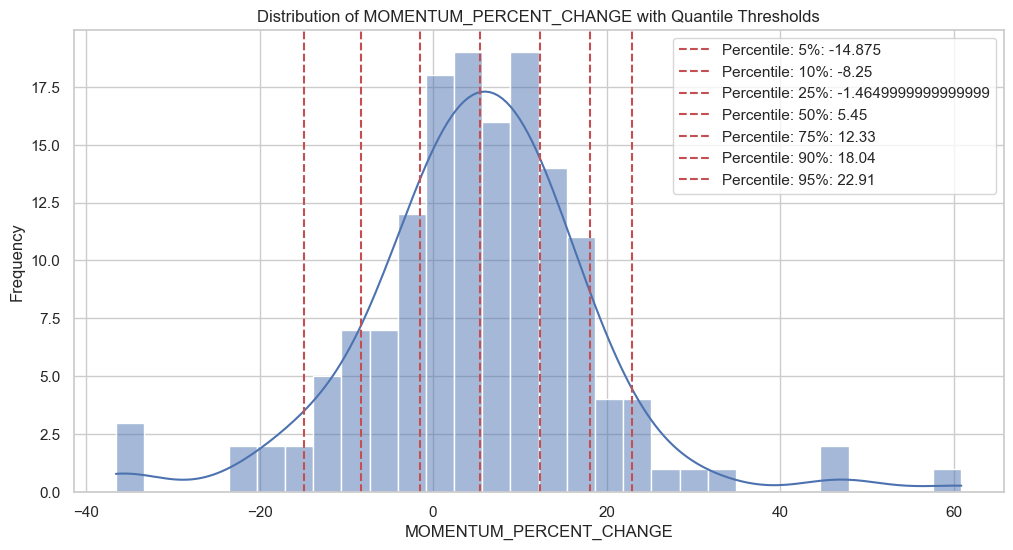

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out NaN values from the MOMENTUM_PERCENT_CHANGE column for plotting
filtered_momentum_percent_change = latest_df["MOMENTUM_PERCENT_CHANGE"].dropna()[:-60]

# Plot the distribution of the MOMENTUM_PERCENT_CHANGE column
quantiles = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]

# Calculate the quantile values from the 'MOMENTUM_PERCENT_CHANGE' column
quantile_values = filtered_momentum_percent_change.quantile(quantiles).tolist()
quantile_map = dict(zip(quantiles, quantile_values))

# Plot the distribution with the quantile thresholds
plt.figure(figsize=(12, 6))
sns.histplot(filtered_momentum_percent_change, bins=30, kde=True)
for idx, q_value in enumerate(quantile_values):
    plt.axvline(
        x=q_value,
        color="r",
        linestyle="--",
        label=f"Percentile: {quantiles[idx]*100:.0f}%: {q_value}",
    )

plt.title("Distribution of MOMENTUM_PERCENT_CHANGE with Quantile Thresholds")
plt.xlabel("MOMENTUM_PERCENT_CHANGE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [17]:
latest_df[latest_df["MOMENTUM_PERCENT_CHANGE"].isna()]

,MONTH,Close,MOMENTUM_PERCENT_CHANGE
0,Dec-05,1420.49,NaN
1,Jan-06,1557.13,NaN
2,Feb-06,1605.73,NaN


In [18]:
def switch(
    latest_df,
    col_name: str = "SWITCH_DYNAMIC",
    initial_value: str = "MOMENTUM",
    to_cash: float = -1.96,
    to_momentum: float = 12.0,
) -> pd.DataFrame:
    df = latest_df.copy()
    # Remove any rows where all values are NaN before proceeding
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    switch_list = []
    # Loop through the DataFrame to populate the SWITCH_DYNAMIC column based on the thresholds
    for idx in range(len(df)):
        if idx == 0:
            switch_list.append(initial_value)
            continue
        prev_row = switch_list[idx - 1]
        current_row = df.iloc[idx]
        momentum_change = current_row.get("MOMENTUM_PERCENT_CHANGE")
        if pd.isna(momentum_change):
            switch_value = initial_value
        elif momentum_change < to_cash:
            switch_value = "CASH"
        elif momentum_change > to_momentum:
            switch_value = "MOMENTUM"
        else:
            switch_value = prev_row

        switch_list.append(switch_value)

    df[col_name] = switch_list
    return df


switch_df = switch(
    latest_df=latest_df,
    col_name="SWITCH_DYNAMIC",
    initial_value="MOMENTUM",
    to_cash=quantile_map[0.1],
    to_momentum=quantile_map[0.5],
)
switch_df = switch(
    latest_df=switch_df,
    col_name="SWITCH_DYNAMIC_OPTIMISTIC",
    initial_value="MOMENTUM",
    to_cash=quantile_map[0.1],
    to_momentum=quantile_map[0.25],
)
switch_df = switch(
    latest_df=switch_df,
    col_name="SWITCH_DYNAMIC_PESSIMISTIC",
    initial_value="MOMENTUM",
    to_cash=quantile_map[0.5],
    to_momentum=quantile_map[0.75],
)
switch_df[switch_df.isna().any(axis=1)]

,MONTH,Close,MOMENTUM_PERCENT_CHANGE,SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC


In [19]:
switch_df["SWITCH_DYNAMIC"].value_counts(), switch_df[
    "SWITCH_DYNAMIC_OPTIMISTIC"
].value_counts(), switch_df["SWITCH_DYNAMIC_PESSIMISTIC"].value_counts()

(SWITCH_DYNAMIC
 MOMENTUM    170
 CASH         41
 Name: count, dtype: int64,
 SWITCH_DYNAMIC_OPTIMISTIC
 MOMENTUM    177
 CASH         34
 Name: count, dtype: int64,
 SWITCH_DYNAMIC_PESSIMISTIC
 CASH        136
 MOMENTUM     75
 Name: count, dtype: int64)

In [20]:
switch_df[48:]

,MONTH,Close,MOMENTUM_PERCENT_CHANGE,SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC
48,Mar-10,2811.48,1.84,MOMENTUM,MOMENTUM,CASH
49,Apr-10,2879.24,8.81,MOMENTUM,MOMENTUM,CASH
50,May-10,2750.12,2.79,MOMENTUM,MOMENTUM,CASH
51,Jun-10,2826.50,0.53,MOMENTUM,MOMENTUM,CASH
52,Jul-10,2969.26,3.13,MOMENTUM,MOMENTUM,CASH
...,...,...,...,...,...,...
206,May-23,20459.90,14.36,MOMENTUM,MOMENTUM,MOMENTUM
207,Jun-23,21312.90,16.74,MOMENTUM,MOMENTUM,MOMENTUM
208,Jul-23,22275.85,15.32,MOMENTUM,MOMENTUM,MOMENTUM
209,Aug-23,22211.65,8.56,MOMENTUM,MOMENTUM,MOMENTUM


In [21]:
def add_amount_based_on_strategy(
    df: pd.DataFrame,
    strategy: str,
    initial_amount: float = 1000.0,
    momentum_col: str = "Close",
) -> pd.DataFrame:
    """
    Adds an 'AMOUNT_<STRATEGY>' column to the DataFrame based on the given cash-only strategy.

    Parameters:
        df (pd.DataFrame): The DataFrame to which the new column will be added.
        strategy (str): The strategy column based on which the amount will be calculated.
        initial_amount (float): The initial amount of investment. Default is 1000 INR.
        momentum_col (str): The column representing the momentum TRI. Default is 'NIFTY 200 MOMENTUM 30 TRI'.

    Returns:
        pd.DataFrame: DataFrame with the new 'AMOUNT_<STRATEGY>' column added.
    """
    df_copy = df.copy()
    amount_list = [initial_amount]  # Start with the initial amount
    amount_col = f"AMOUNT_{strategy}"

    for idx in range(1, len(df)):
        prev_row = df_copy.iloc[idx - 1]
        current_row = df_copy.iloc[idx]

        # Use the strategy from the previous month to decide the current month's amount
        if prev_row[strategy] == "MOMENTUM":
            current_amount = amount_list[-1] * (
                current_row[momentum_col] / prev_row[momentum_col]
            )
        else:
            current_amount = amount_list[-1]  # In CASH, just copy the previous value

        amount_list.append(current_amount)

    df_copy[amount_col] = amount_list  # No more slicing, now the lengths should match

    return df_copy


amount_df = add_amount_based_on_strategy(
    switch_df, strategy="SWITCH_DYNAMIC_OPTIMISTIC", initial_amount=1000.0
)
amount_df = add_amount_based_on_strategy(
    amount_df, strategy="SWITCH_DYNAMIC", initial_amount=1000.0
)
amount_df = add_amount_based_on_strategy(
    amount_df, strategy="SWITCH_DYNAMIC_PESSIMISTIC", initial_amount=1000.0
)

# round the values to 2 decimal places
amount_df["AMOUNT_SWITCH_DYNAMIC"] = amount_df["AMOUNT_SWITCH_DYNAMIC"].round(2)
amount_df["AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC"] = amount_df[
    "AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC"
].round(2)
amount_df[42:90]

,MONTH,Close,MOMENTUM_PERCENT_CHANGE,SWITCH_DYNAMIC,SWITCH_DYNAMIC_OPTIMISTIC,SWITCH_DYNAMIC_PESSIMISTIC,AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC,AMOUNT_SWITCH_DYNAMIC,AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC
42,Sep-09,2561.75,20.29,MOMENTUM,MOMENTUM,MOMENTUM,2562.15,2562.15,1904.690868
43,Oct-09,2444.19,2.91,MOMENTUM,MOMENTUM,CASH,2444.57,2444.57,1817.283643
44,Nov-09,2681.19,12.87,MOMENTUM,MOMENTUM,MOMENTUM,2681.61,2681.61,1817.283643
45,Dec-09,2760.61,7.76,MOMENTUM,MOMENTUM,MOMENTUM,2761.04,2761.04,1871.113721
46,Jan-10,2646.08,8.26,MOMENTUM,MOMENTUM,MOMENTUM,2646.49,2646.49,1793.486438
47,Feb-10,2675.55,-0.21,MOMENTUM,MOMENTUM,CASH,2675.97,2675.97,1813.460908
48,Mar-10,2811.48,1.84,MOMENTUM,MOMENTUM,CASH,2811.92,2811.92,1813.460908
49,Apr-10,2879.24,8.81,MOMENTUM,MOMENTUM,CASH,2879.69,2879.69,1813.460908
50,May-10,2750.12,2.79,MOMENTUM,MOMENTUM,CASH,2750.55,2750.55,1813.460908
51,Jun-10,2826.50,0.53,MOMENTUM,MOMENTUM,CASH,2826.94,2826.94,1813.460908


In [22]:
# number of changes from CASH to MOMENTUM and vice versa
def change_count(amount_df, strategy: str = "SWITCH_DYNAMIC"):
    df = amount_df.copy()
    df["CHANGE"] = df[strategy].shift(1) != df[strategy]
    df["CHANGE"] = df["CHANGE"].astype(int)
    return df["CHANGE"].sum()


# Number of changes from CASH to MOMENTUM
def sell_count(amount_df, strategy: str = "SWITCH_DYNAMIC"):
    df = amount_df.copy()
    df["CHANGE"] = df[strategy].shift(1) != df[strategy]
    df["CHANGE"] = df["CHANGE"].astype(int)
    df["SELL"] = df["CHANGE"] * (df[strategy] == "CASH")
    return df["SELL"].sum()


pd.DataFrame(
    {
        "Strategy": [
            "SWITCH_DYNAMIC",
            "SWITCH_DYNAMIC_OPTIMISTIC",
            "SWITCH_DYNAMIC_PESSIMISTIC",
        ],
        "Change Count": [
            change_count(amount_df, strategy="SWITCH_DYNAMIC"),
            change_count(amount_df, strategy="SWITCH_DYNAMIC_OPTIMISTIC"),
            change_count(amount_df, strategy="SWITCH_DYNAMIC_PESSIMISTIC"),
        ],
        "Sell Count": [
            sell_count(amount_df, strategy="SWITCH_DYNAMIC"),
            sell_count(amount_df, strategy="SWITCH_DYNAMIC_OPTIMISTIC"),
            sell_count(amount_df, strategy="SWITCH_DYNAMIC_PESSIMISTIC"),
        ],
    }
)

,Strategy,Change Count,Sell Count
0,SWITCH_DYNAMIC,21,10
1,SWITCH_DYNAMIC_OPTIMISTIC,23,11
2,SWITCH_DYNAMIC_PESSIMISTIC,31,15


In [23]:
amount_df.to_csv("../data/BackTestAmounts.csv", index=False)

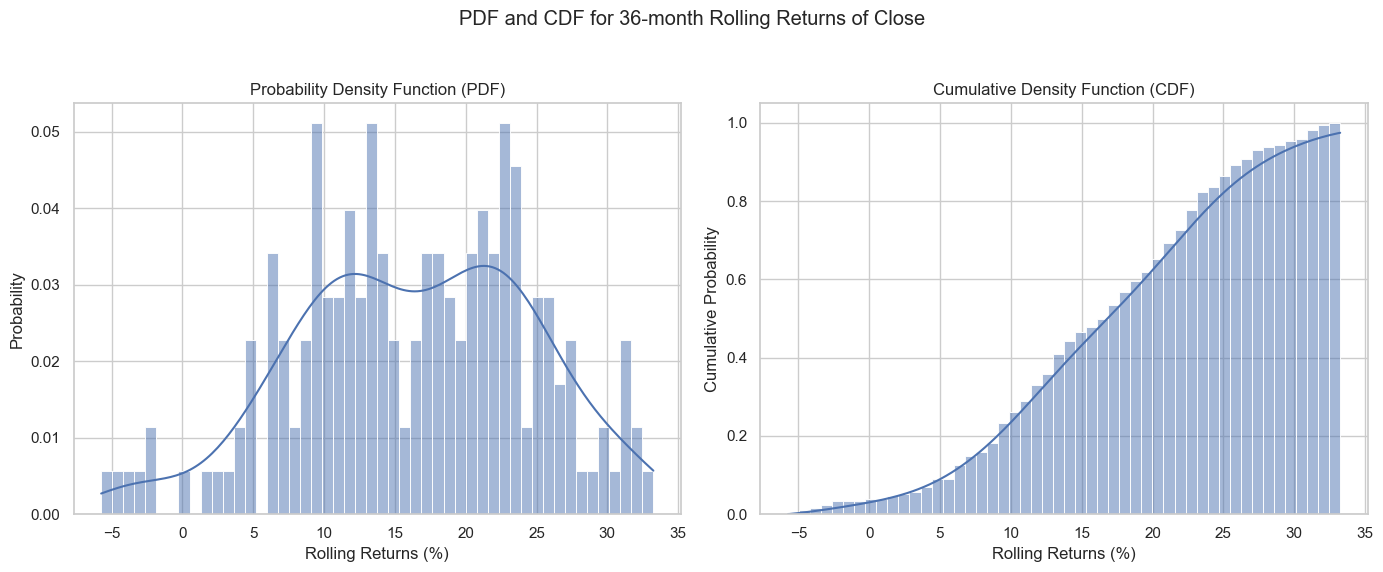

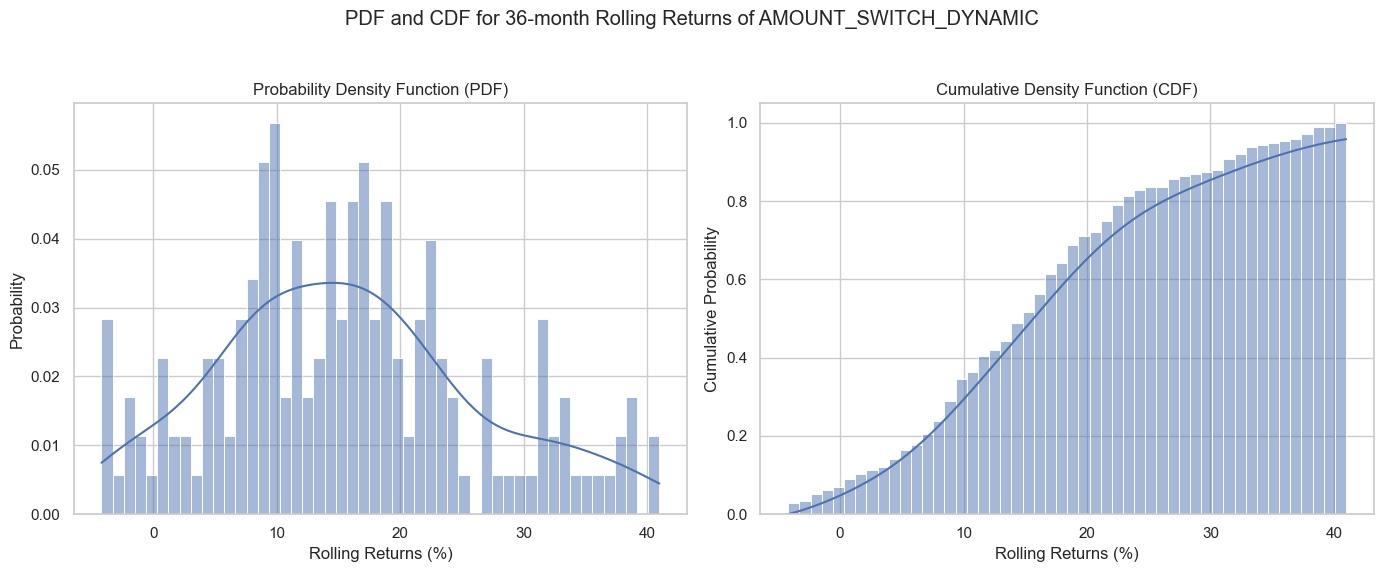

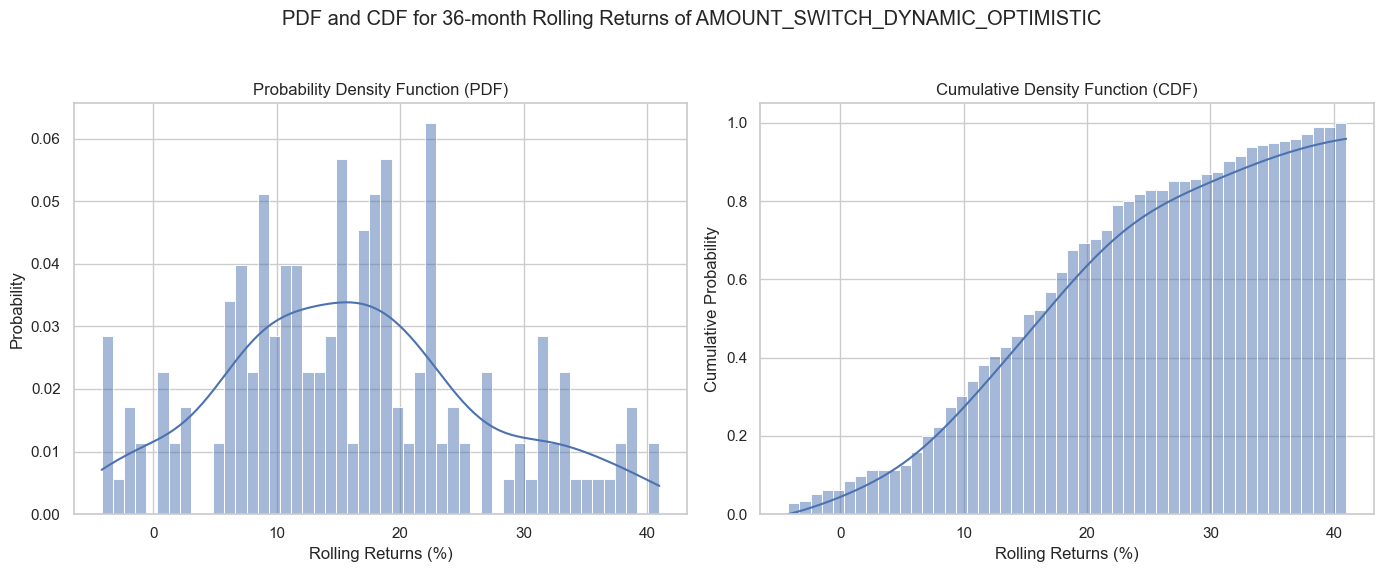

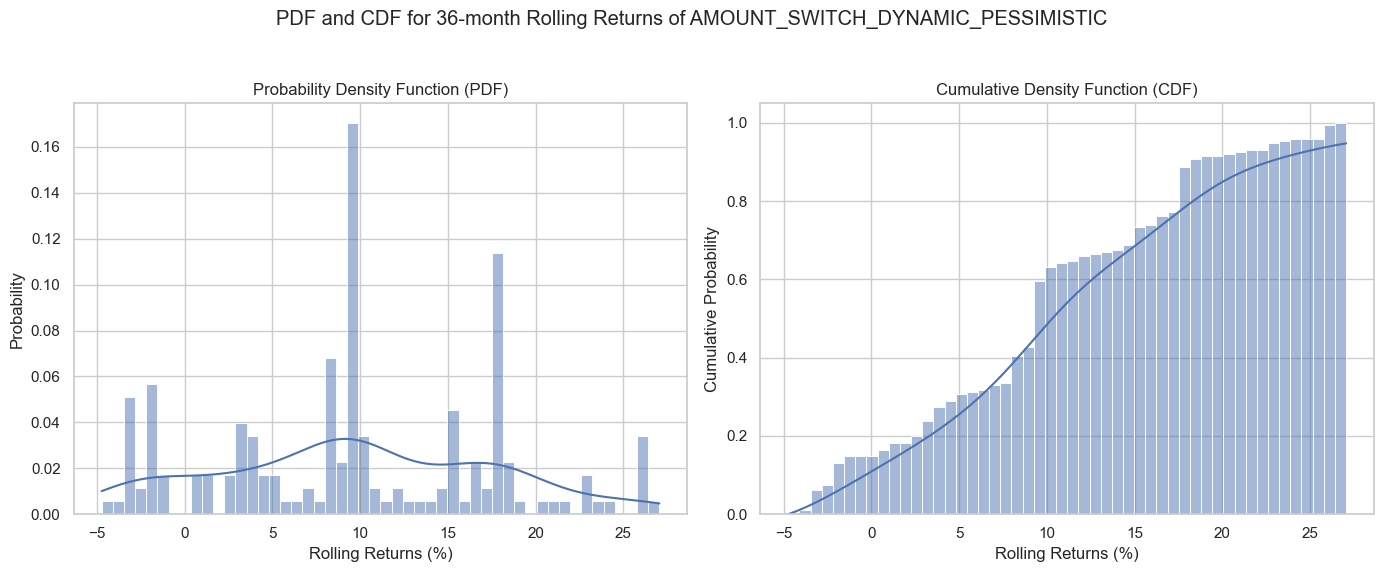

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to calculate rolling returns
def calculate_rolling_returns(
    df: pd.DataFrame, col_name: str, months: int
) -> pd.Series:
    start_values = df[col_name].shift(months - 1)
    end_values = df[col_name]
    cagr = ((end_values / start_values) ** (1 / (months / 12))) - 1
    return cagr * 100  # convert to percentage


def plot_pdf_cdf(df: pd.DataFrame, col_name: str, months: int):
    rolling_returns = calculate_rolling_returns(df, col_name, months).dropna()
    total_rolling_windows = len(rolling_returns)
    sns.set(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plt.suptitle(f"PDF and CDF for {months}-month Rolling Returns of {col_name}")

    # PDF Plot
    sns.histplot(rolling_returns, bins=50, kde=True, stat="probability", ax=axes[0])
    axes[0].set_title("Probability Density Function (PDF)")
    axes[0].set_xlabel("Rolling Returns (%)")
    axes[0].set_ylabel("Probability")

    # CDF Plot
    sns.histplot(
        rolling_returns,
        bins=50,
        kde=True,
        cumulative=True,
        stat="probability",
        ax=axes[1],
    )
    axes[1].set_title("Cumulative Density Function (CDF)")
    axes[1].set_xlabel("Rolling Returns (%)")
    axes[1].set_ylabel("Cumulative Probability")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


import warnings

warnings.filterwarnings("ignore")

plot_pdf_cdf(amount_df, "Close", 36)
plot_pdf_cdf(amount_df, "AMOUNT_SWITCH_DYNAMIC", 36)
plot_pdf_cdf(amount_df, "AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC", 36)
plot_pdf_cdf(amount_df, "AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC", 36)

In [26]:
from typing import List


# Helper function to calculate CAGR
def cagr(end_value, start_value, periods):
    return (end_value / start_value) ** (1 / periods) - 1


# Function to calculate common backtest statistics
def backtest_stats(
    df: pd.DataFrame, columns: List[str], rf_rate: float = 0.07
) -> pd.DataFrame:
    stats = {}
    for col in columns:
        col_stats = {}

        # Calculate CAGR
        cagr_value = cagr(df[col].iloc[-1], df[col].iloc[0], len(df) / 12)
        col_stats["CAGR"] = cagr_value

        # Calculate annualized risk
        df["returns"] = df[col].pct_change().dropna()
        annual_risk = df["returns"].std() * np.sqrt(12)
        col_stats["Annualized Risk"] = annual_risk

        # Sharpe Ratio
        sharpe_ratio = (cagr_value - rf_rate) / annual_risk
        col_stats["Sharpe Ratio"] = sharpe_ratio

        # Max Drawdown
        df["cum_return"] = (1 + df["returns"]).cumprod()
        df["cum_roll_max"] = df["cum_return"].cummax()
        df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
        df["drawdown_pct"] = df["drawdown"] / df["cum_roll_max"]
        max_drawdown = df["drawdown_pct"].max()
        col_stats["Max Drawdown"] = max_drawdown

        # Sortino Ratio
        df["downside_returns"] = 0
        target = 0
        mask = df["returns"] < target
        df.loc[mask, "downside_returns"] = df["returns"] ** 2
        expected_return = df["returns"].mean()
        downside_std = np.sqrt(df["downside_returns"].mean())
        sortino_ratio = (expected_return - rf_rate) / downside_std
        col_stats["Sortino Ratio"] = sortino_ratio

        # Calmar Ratio
        calmar_ratio = cagr_value / max_drawdown
        col_stats["Calmar Ratio"] = calmar_ratio

        stats[col] = col_stats

    return pd.DataFrame(stats)


backtest_stats(
    amount_df,
    columns=[
        "Close",
        "AMOUNT_SWITCH_DYNAMIC",
        "AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC",
        "AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC",
    ],
)

,Close,AMOUNT_SWITCH_DYNAMIC,AMOUNT_SWITCH_DYNAMIC_OPTIMISTIC,AMOUNT_SWITCH_DYNAMIC_PESSIMISTIC
CAGR,0.156268,0.144594,0.148104,0.099934
Annualized Risk,0.231196,0.189103,0.191194,0.137420
Sharpe Ratio,0.373139,0.394464,0.408507,0.217828
Max Drawdown,0.622765,0.353975,0.370377,0.189141
Sortino Ratio,-1.243324,-1.724023,-1.695439,-3.047368
Calmar Ratio,0.250927,0.408488,0.399874,0.528357
